In [1]:
import os
import numpy as np
import json
import argparse
import torch
from matplotlib import pyplot as plt

import config
from train_MLP import FMRIDataset, MLP, calc_loss
from GPT import GPT
from StimulusModel import LMFeatures
from utils_stim import get_stim
from utils_resp import get_resp
from utils_ridge.ridge import ridge, bootstrap_ridge

/chronos_data/rrao/conda/envs/thought2text/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/chronos_data/rrao/conda/envs/thought2text/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/chronos_data/rrao/conda/envs/thought2text/lib/python3.10/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(42)

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--subject", type = str, default = "S1")
parser.add_argument("--gpt", type = str, default = "perceived", choices=["perceived", "imagined"])
parser.add_argument("--sessions", nargs = "+", type = int, 
    default = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 18, 20])
parser.add_argument("--model", type = str, default = "EM_BASE", choices=["EM_BASE", "EM_MLP", "EM_GPT2"])
parser.add_argument("--load_path", type = str, required=True, help="Specify path to load checkpoint parameters")
args = parser.parse_args("--subject S1 --model EM_MLP --load_path ../models/S1/mlp_perceived_1e-3_1e-5.pth".split())

In [4]:
# training stories
stories = []
with open(os.path.join(config.DATA_TRAIN_DIR, "sess_to_story.json"), "r") as f:
    sess_to_story = json.load(f)
for sess in args.sessions:
    stories.extend(sess_to_story[str(sess)])

In [5]:
# load gpt
with open(os.path.join(config.DATA_LM_DIR, args.gpt, "vocab.json"), "r") as f:
    gpt_vocab = json.load(f)
gpt = GPT(path = os.path.join(config.DATA_LM_DIR, args.gpt, "model"), vocab = gpt_vocab, device = config.GPT_DEVICE)
features = LMFeatures(model = gpt, layer = config.GPT_LAYER, context_words = config.GPT_WORDS)

In [13]:
# Prepare stimulus + response data
em_cp = np.load("../models/S1/encoding_model_perceived.npz")
rstim, tr_stats, word_stats = get_stim(stories, features)
rresp = get_resp(args.subject, stories, stack = True)[:, em_cp["voxels"]]
train_dataset = FMRIDataset(rstim, rresp)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

#### EM BASE

In [14]:
rstim = torch.from_numpy(rstim).float().to(DEVICE)
rresp = torch.from_numpy(rresp).float().to(DEVICE)
weights = torch.from_numpy(em_cp["weights"])[:, em_cp["voxels"]].float().to(DEVICE)

In [21]:
# get response predictions
presp = torch.matmul(rstim, weights)
res = torch.square(presp - rresp)

In [23]:
res = torch.mean(res, dim=0)

torch.Size([10000])

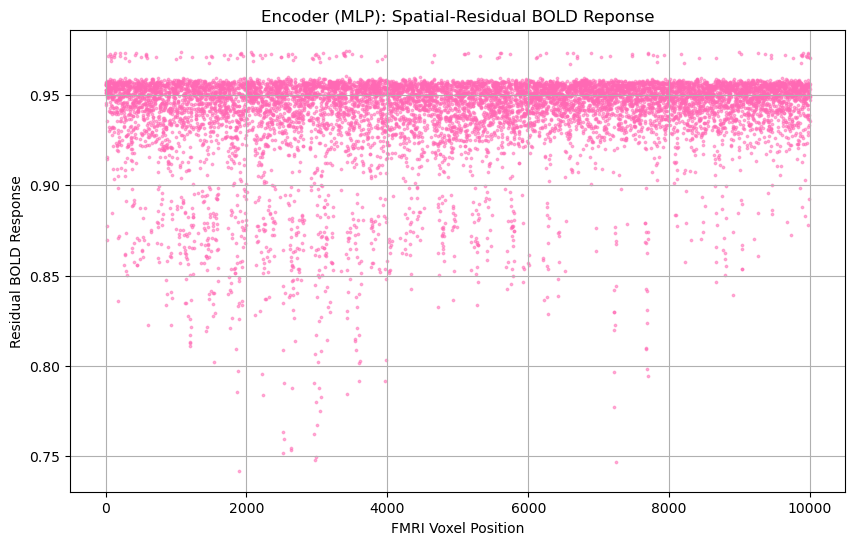

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(res)), res.cpu().numpy(), s=3, alpha=0.5, color="hotpink")
plt.xlabel("FMRI Voxel Position")
plt.ylabel("Residual BOLD Response")
plt.title("Encoder (MLP): Spatial-Residual BOLD Reponse")
plt.grid(True)
plt.show()

#### EM MLP

In [7]:
model = MLP(3072, config.VOXELS).to(DEVICE)

# Load weights
model_state_dict = torch.load(args.load_path, map_location=DEVICE)
if "module." in list(model_state_dict.keys())[0]:
    model_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [48]:
presps = []
residuals = []
model.eval()
for idx, batch in enumerate(train_loader):
    rstim, rresp = batch[0].to(DEVICE), batch[1].to(DEVICE)
    presp = model(rstim)
    presps.append(presp)
    residuals.append(torch.square(presp - rresp))

In [49]:
presps = torch.cat(presps)
avg_presp = torch.mean(presps, dim=0)
residuals = torch.cat(residuals)
avg_res = torch.mean(residuals, dim=0)
print(avg_presp.shape)
print(avg_res.shape)

torch.Size([10000])

In [53]:
print(torch.max(avg_presp))
print(torch.min(avg_presp))

tensor(0.0665, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.0652, device='cuda:0', grad_fn=<MinBackward1>)


In [51]:
presp_matrix = avg_presp.reshape(100, 100)
print(presp_matrix.shape)
res_matrix = avg_res.reshape(100, 100)
print(res_matrix.shape)

torch.Size([100, 100])
torch.Size([100, 100])


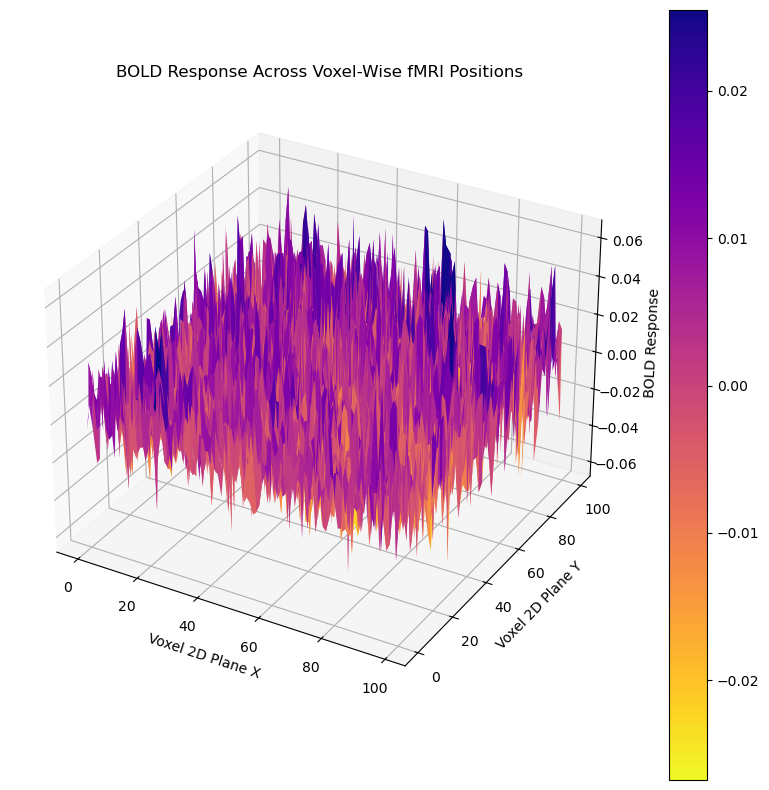

In [55]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

indeces = np.arange(0, 100)
x, y = np.meshgrid(indeces, indeces)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, presp_matrix.detach().cpu().numpy(), cmap='plasma_r')

ax.set_xlabel('Voxel 2D Plane X')
ax.set_ylabel('Voxel 2D Plane Y')
ax.set_zlabel('BOLD Response')
ax.set_title('BOLD Response Across Voxel-Wise fMRI Positions')

fig.colorbar(surf)

plt.show()

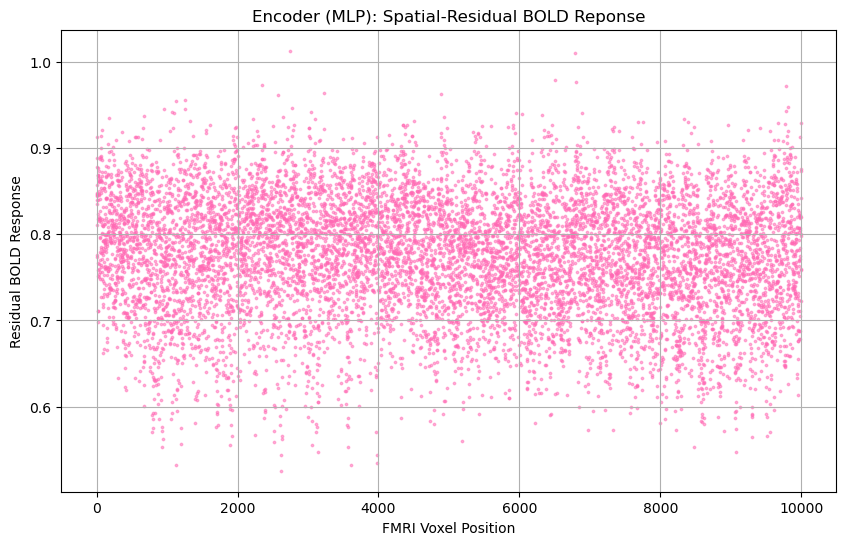

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(avg_res)), avg_res.detach().cpu().numpy(), s=3, alpha=0.5, color="hotpink")
plt.xlabel("FMRI Voxel Position")
plt.ylabel("Residual BOLD Response")
plt.title("Encoder (MLP): Spatial-Residual BOLD Reponse")
plt.grid(True)
plt.show()

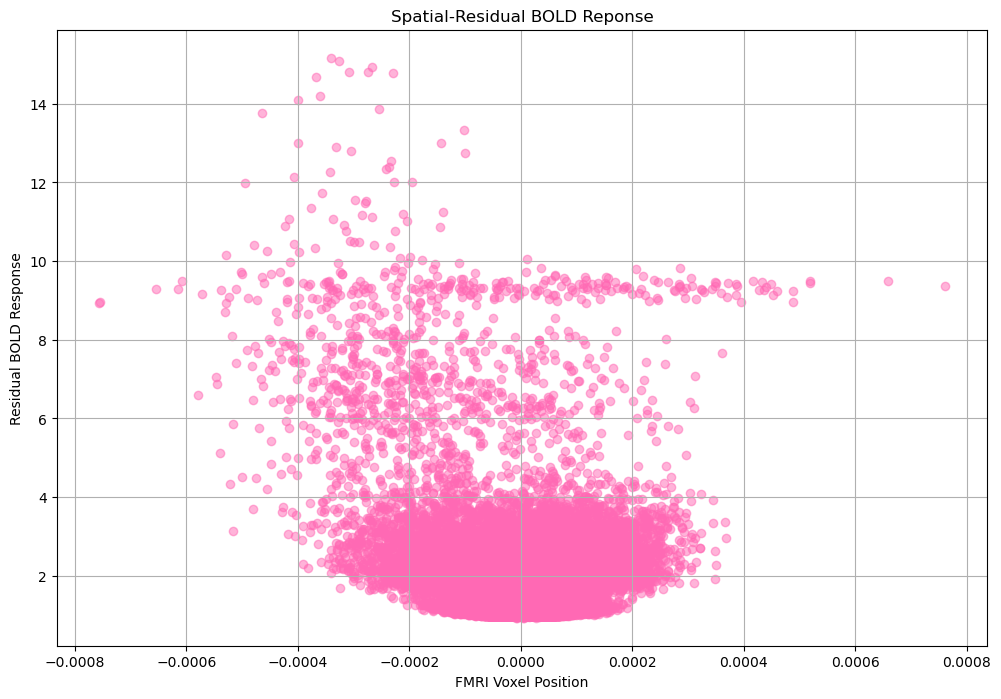

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(avg_presp.cpu().numpy(), avg_res.cpu().numpy(), alpha=0.5, color="hotpink")
plt.xlabel("FMRI Voxel Position")
plt.ylabel("Residual BOLD Response")
plt.title("Spatial-Residual BOLD Reponse")
plt.grid(True)
plt.show()